## Importações

In [31]:
import pandas as pd
from math import floor
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from sklearn.naive_bayes import GaussianNB
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from scipy.stats import norm
from sklearn.metrics import accuracy_score,classification_report, f1_score, confusion_matrix,recall_score,precision_score

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold,train_test_split,cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import chi2,f_classif, f_oneway,f_regression,r_regression, mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler

## Funções Comuns

In [32]:
def funcPlotMatriz(y_test, classificar):
    matriz_de_confusao = confusion_matrix(y_test, classificar)
    sns.heatmap(matriz_de_confusao, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
    plt.show()


def funcMetricas(df_metricas,modelo_Versao, df,quant_columns,Hyper_Parametros,y_test, classificar):
    metricas = [
        modelo_Versao,
        df,
        quant_columns,
        Hyper_Parametros,
        accuracy_score(y_test, classificar), 
        round(recall_score(y_test, classificar, pos_label=0,average='macro'),2),
        round(precision_score(y_test, classificar, pos_label=0,average='macro'),2),
        round(f1_score(y_test, classificar, pos_label=0,average='macro'),2)
        ]
    
    nova_linha_df = pd.DataFrame([metricas], columns=df_metricas.columns)

    df_metricas = pd.concat([df_metricas, nova_linha_df], ignore_index=True)
    
    return df_metricas


## Extraindo a Base

In [33]:
df_original = pd.read_excel('..\dados\df_original.xlsx')

df = df_original.copy()

display(df)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.620000,64.000000,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,21,1.520000,56.000000,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.800000,77.000000,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.800000,87.000000,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.780000,89.800000,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20,1.710730,131.408528,yes,yes,3,3,Sometimes,no,2,no,2,1,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21,1.748584,133.742943,yes,yes,3,3,Sometimes,no,2,no,1,1,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22,1.752206,133.689352,yes,yes,3,3,Sometimes,no,2,no,1,1,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24,1.739450,133.346641,yes,yes,3,3,Sometimes,no,3,no,1,1,Sometimes,Public_Transportation,Obesity_Type_III


### Dividindo o Dataframe em Valor Explicativo e Resposta

In [34]:
df_x ,df_y= df.iloc[:, :-1],df.iloc[:, -1]

df_y = pd.DataFrame(df_y)
display(df_x)
display(df_y)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Female,21,1.620000,64.000000,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation
1,Female,21,1.520000,56.000000,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation
2,Male,23,1.800000,77.000000,yes,no,2,3,Sometimes,no,2,no,2,1,Frequently,Public_Transportation
3,Male,27,1.800000,87.000000,no,no,3,3,Sometimes,no,2,no,2,0,Frequently,Walking
4,Male,22,1.780000,89.800000,no,no,2,1,Sometimes,no,2,no,0,0,Sometimes,Public_Transportation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20,1.710730,131.408528,yes,yes,3,3,Sometimes,no,2,no,2,1,Sometimes,Public_Transportation
2107,Female,21,1.748584,133.742943,yes,yes,3,3,Sometimes,no,2,no,1,1,Sometimes,Public_Transportation
2108,Female,22,1.752206,133.689352,yes,yes,3,3,Sometimes,no,2,no,1,1,Sometimes,Public_Transportation
2109,Female,24,1.739450,133.346641,yes,yes,3,3,Sometimes,no,3,no,1,1,Sometimes,Public_Transportation


,NObeyesdad
0,Normal_Weight
1,Normal_Weight
2,Normal_Weight
3,Overweight_Level_I
4,Overweight_Level_II
...,...
2106,Obesity_Type_III
2107,Obesity_Type_III
2108,Obesity_Type_III
2109,Obesity_Type_III


### Transformando os Dados Qualitativos em Quantitativos

In [35]:
label_encolder = LabelEncoder()

preprocessador = ColumnTransformer(
    transformers=[
        ('categoria', OrdinalEncoder(), make_column_selector(dtype_include=['object','bool']))
    ],
    remainder='passthrough',  # Mantém as outras colunas inalteradas
    verbose_feature_names_out=False,  # Mantém os nomes originais das colunas
    
)

# Ajustar e transformar o DataFrame usando o preprocessador
df_x_encoded = preprocessador.fit_transform(df_x)

df_y_encoded = label_encolder.fit_transform(df_y)

# Se necessário, converter o resultado de volta para um DataFrame, mantendo os nomes das colunas
df_x_encoded = pd.DataFrame(df_x_encoded, columns=preprocessador.get_feature_names_out())
# Matém a ordem do df original
df_x_encoded = df_x_encoded[df_x.columns]

df_y_encoded = pd.DataFrame(df_y_encoded, columns=df_y.columns)

# df_x_encoded=df_x_encoded[df_x.columns]

df_encoded = df_x_encoded.copy()
df_encoded['NObeyesdad']=df_y_encoded
df_encoded

display(df_x_encoded)
display(df_y_encoded)

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,0.0,21.0,1.620000,64.000000,1.0,0.0,2.0,3.0,2.0,0.0,2.0,0.0,0.0,1.0,3.0,3.0
1,0.0,21.0,1.520000,56.000000,1.0,0.0,3.0,3.0,2.0,1.0,3.0,1.0,3.0,0.0,2.0,3.0
2,1.0,23.0,1.800000,77.000000,1.0,0.0,2.0,3.0,2.0,0.0,2.0,0.0,2.0,1.0,1.0,3.0
3,1.0,27.0,1.800000,87.000000,0.0,0.0,3.0,3.0,2.0,0.0,2.0,0.0,2.0,0.0,1.0,4.0
4,1.0,22.0,1.780000,89.800000,0.0,0.0,2.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0.0,20.0,1.710730,131.408528,1.0,1.0,3.0,3.0,2.0,0.0,2.0,0.0,2.0,1.0,2.0,3.0
2107,0.0,21.0,1.748584,133.742943,1.0,1.0,3.0,3.0,2.0,0.0,2.0,0.0,1.0,1.0,2.0,3.0
2108,0.0,22.0,1.752206,133.689352,1.0,1.0,3.0,3.0,2.0,0.0,2.0,0.0,1.0,1.0,2.0,3.0
2109,0.0,24.0,1.739450,133.346641,1.0,1.0,3.0,3.0,2.0,0.0,3.0,0.0,1.0,1.0,2.0,3.0


,NObeyesdad
0,1
1,1
2,1
3,5
4,6
...,...
2106,4
2107,4
2108,4
2109,4


#### Dividindo os DataFrames de Teste e Treino

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_x_encoded, df_y_encoded, test_size=0.25,random_state=42,shuffle=True)

# Salva o array na memoria para guardar a ordem das colunas
# X_train = np.ascontiguousarray(X_train)
# X_test = np.ascontiguousarray(X_test)

## Modelo GaussianNB

## Teste Simples

In [37]:
classificador_bayes = GaussianNB()

scores = cross_validate(classificador_bayes, X_train, y_train, cv=5, scoring=['accuracy','precision_macro','recall_macro','f1_macro'])
chaves = ['test_accuracy','test_precision_macro','test_recall_macro','test_f1_macro']

scores_avg = [scores[chave].mean() for chave in chaves] 

print(scores)
print(scores_avg)


{'fit_time': array([0.0030005 , 0.00199747, 0.00199819, 0.00199485, 0.00461626]), 'score_time': array([0.01723409, 0.01309443, 0.01408529, 0.01389885, 0.02116036]), 'test_accuracy': array([0.63091483, 0.58990536, 0.57097792, 0.59810127, 0.59493671]), 'test_precision_macro': array([0.64669084, 0.63009078, 0.60692935, 0.63850656, 0.61554283]), 'test_recall_macro': array([0.62677124, 0.58303723, 0.57180792, 0.58341858, 0.58939977]), 'test_f1_macro': array([0.6021248 , 0.56833598, 0.54222647, 0.54278095, 0.56821936])}
[0.596967216387813, 0.6275520726561208, 0.5908869488305444, 0.5647375100504771]


c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\s

In [38]:
classificador_bayes.fit(X_train, y_train)
classificar = classificador_bayes.predict(X_test)
print(classification_report(y_test,classificar))

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.67      0.88      0.76        68
           1       0.52      0.33      0.41        78
           2       0.42      0.61      0.50        94
           3       0.69      0.92      0.79        75
           4       0.96      0.99      0.97        79
           5       0.45      0.28      0.35        71
           6       0.54      0.24      0.33        63

    accuracy                           0.62       528
   macro avg       0.61      0.61      0.59       528
weighted avg       0.61      0.62      0.59       528



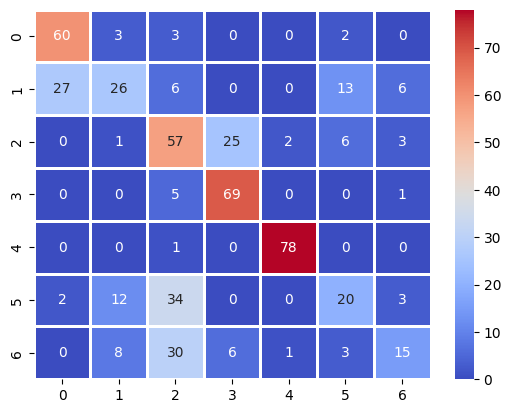

In [39]:
funcPlotMatriz(y_test, classificar)

## Entendendo o Resultado do Modelo

### Distribuição dos Dados

C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_32052\382664771.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Age'], shade=True, color="b", ax=axs[0, 0])
C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_32052\382664771.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Height'], shade=True, color="b", ax=axs[0, 1])
C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_32052\382664771.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Weight'], shade=True, color="b", ax=axs[0, 2])
C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_32052\382664771.py:7: UserWarning: 

`distplot

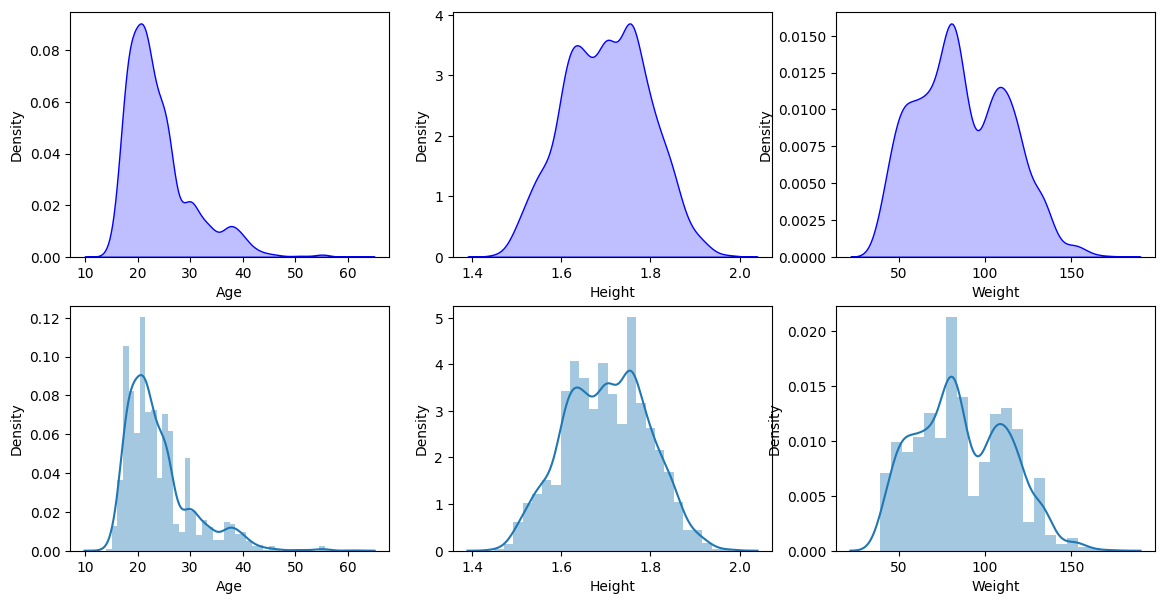

In [40]:
fig, axs = plt.subplots(2, 3, figsize=(14, 7))

sns.kdeplot(df['Age'], shade=True, color="b", ax=axs[0, 0])
sns.kdeplot(df['Height'], shade=True, color="b", ax=axs[0, 1])
sns.kdeplot(df['Weight'], shade=True, color="b", ax=axs[0, 2])

sns.distplot( a=df["Age"], hist=True, kde=True, rug=False, ax=axs[1, 0])
sns.distplot( a=df["Height"], hist=True, kde=True, rug=False, ax=axs[1, 1])
sns.distplot( a=df["Weight"], hist=True, kde=True, rug=False, ax=axs[1, 2])

plt.show()

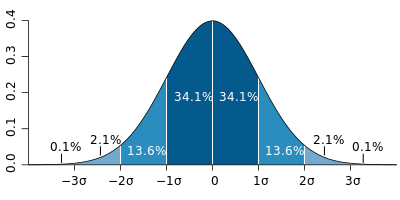

O modelo "GaussianNB" assume que os dados quantitativos seguem uma distribuição normal (gaussiana). Ao analisarmos os gráficos plotados, fica claro que as colunas "Age" e "Weight" estão bem diferentes da distribuição normal; por outro lado, a coluna "Height" se aproxima muito da distribuição normal.

Além disso, o dataset possui em grande maioria colunas qualitativas, que não se adequam bem ao modelo GaussianNB. Quando codificamos estas colunas com OrdinalEncoder, o modelo tratará elas como se fossem valores quantitativos, aplicando a suposição de distribuição normal. Assim, levando a irregularidades no modelo, já que variáveis categóricas não seguem distribuições gaussianas (na maioria dos casos).

Com as plotagens a baixo, se comprova a disregularidade na distribuição das colunas qualitativas transformadas em quantitativas. Mostrando sua deistribuição e como seria a distribuição normal.

C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_32052\3760981640.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_encoded[col], shade=True, color="b", ax=axs[i])
C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_32052\3760981640.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_encoded[col], shade=True, color="b", ax=axs[i])
C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_32052\3760981640.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_encoded[col], shade=True, color="b", ax=axs[i])
C:\Users\arthurdomingos-ieg\AppData\Local\Temp\ipykernel_32052\3760981640.py:6: FutureWarning: 



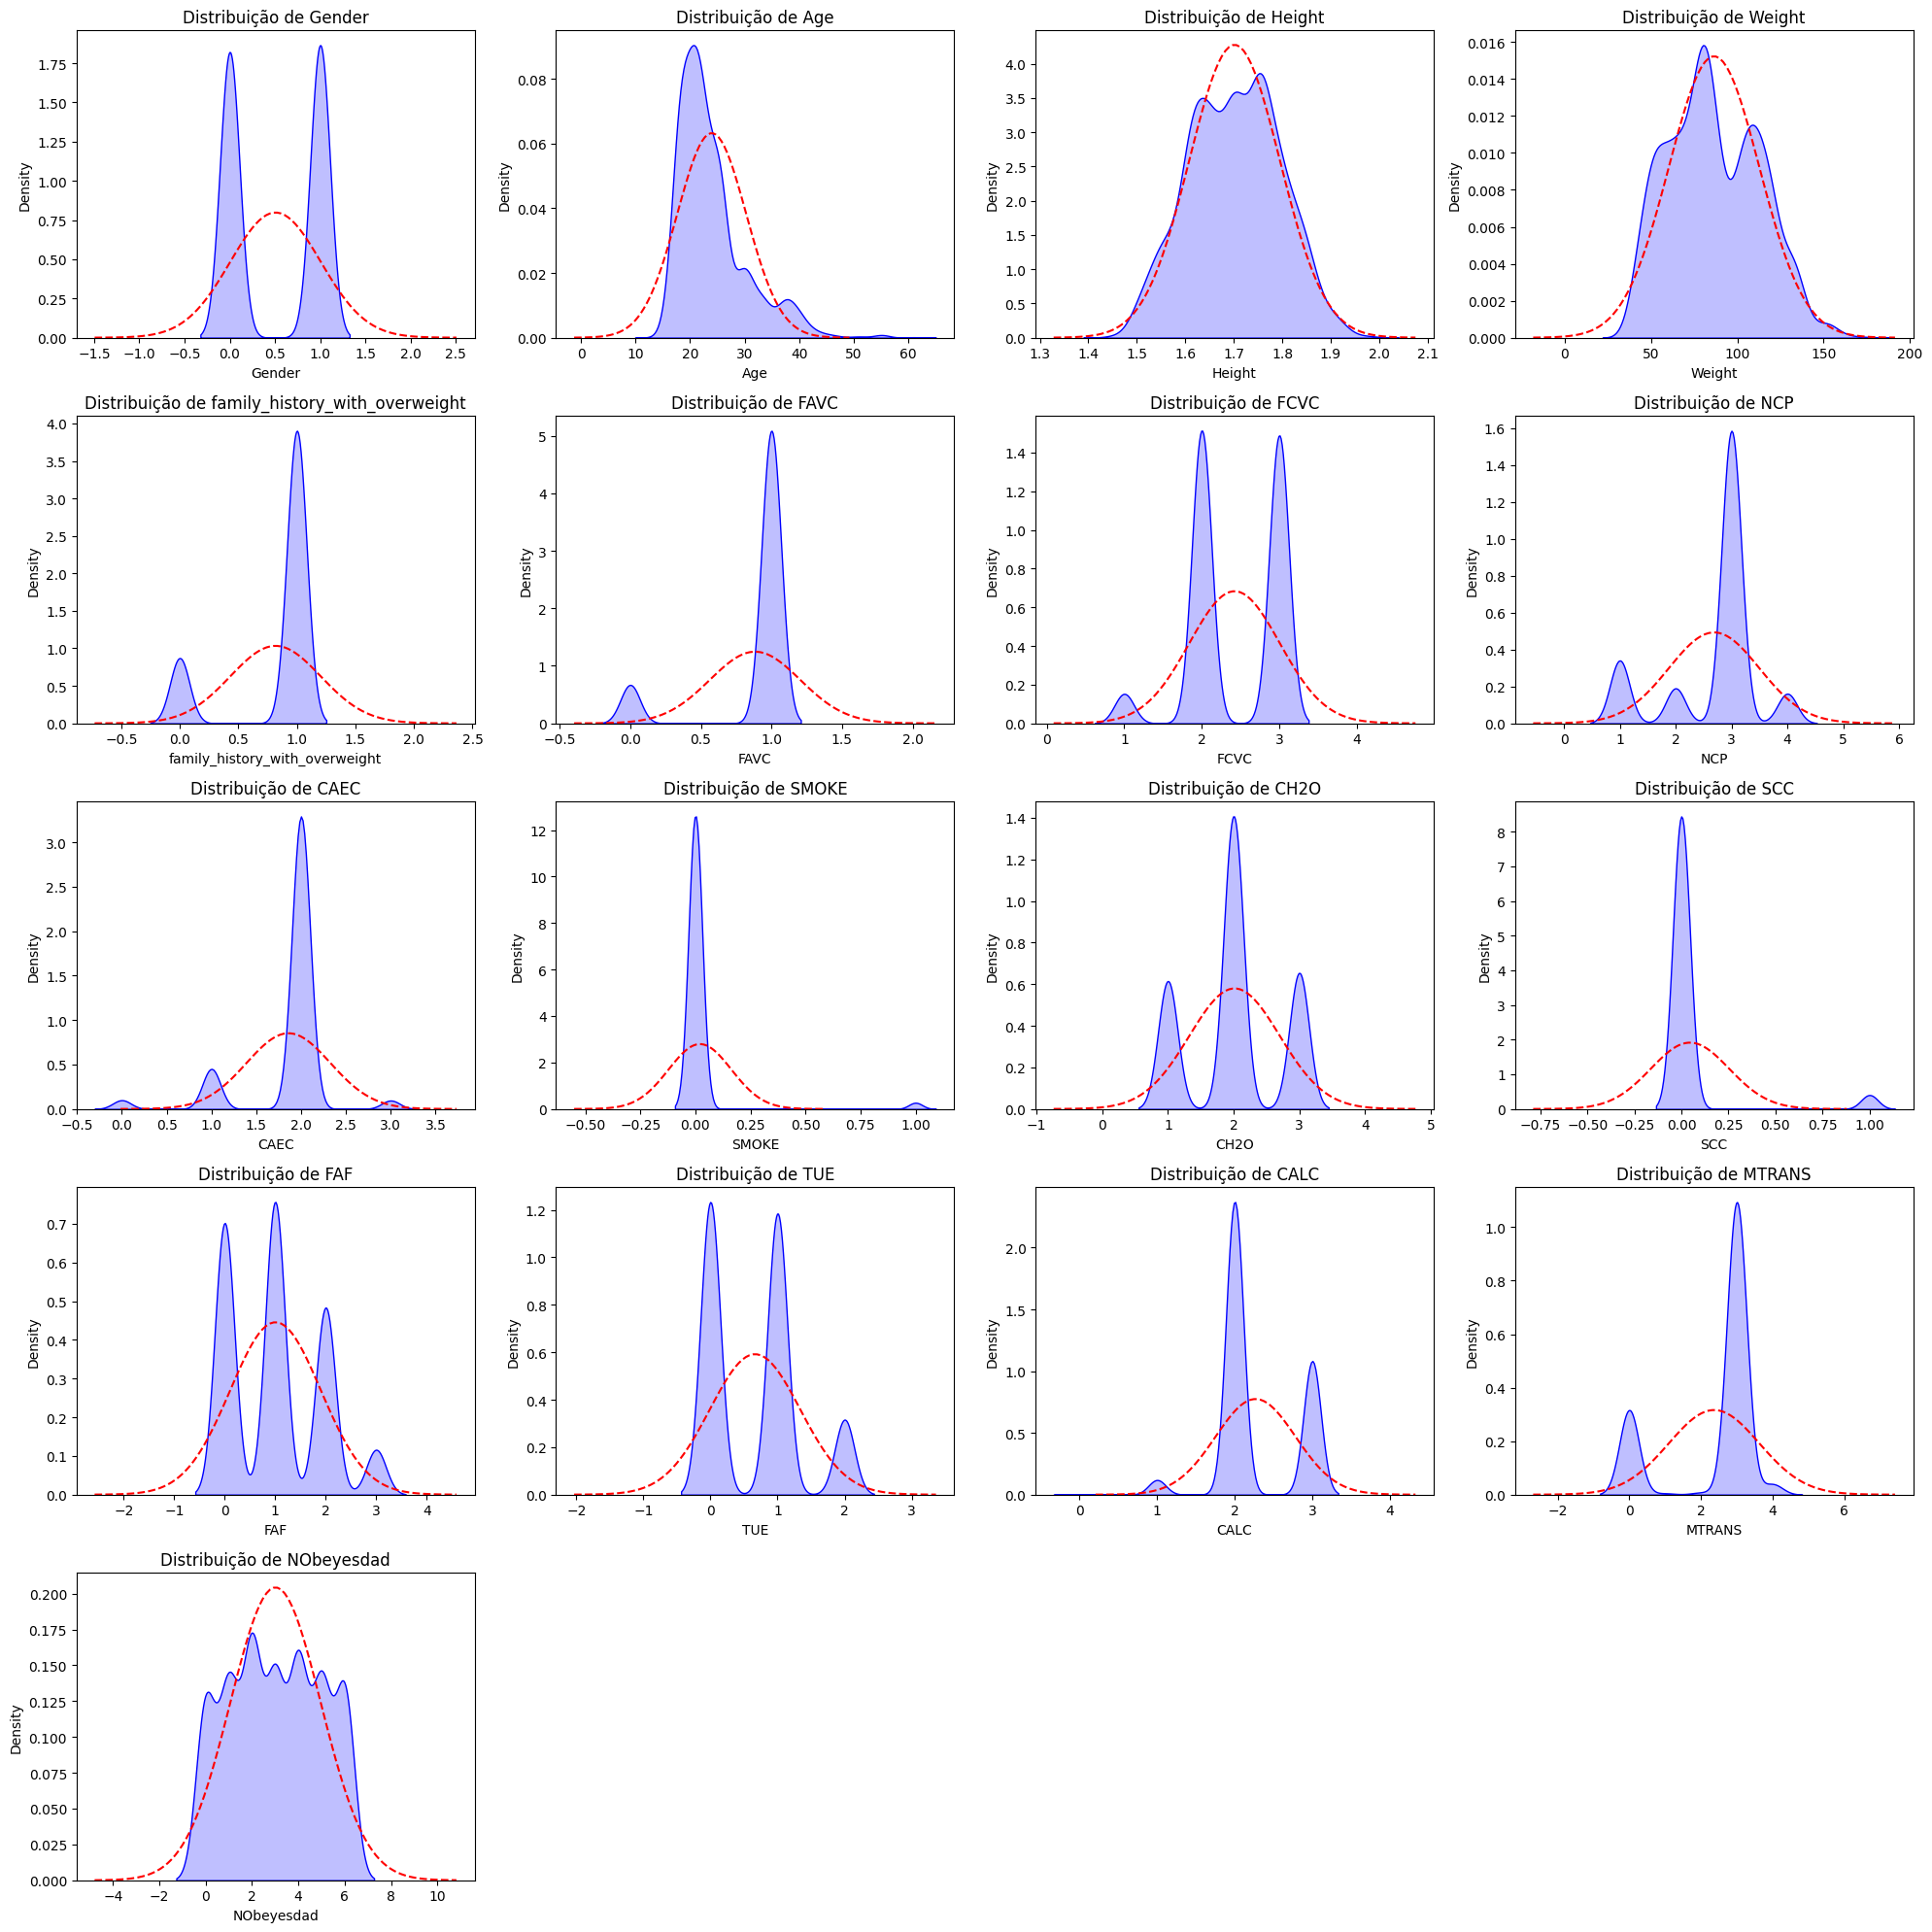

In [41]:
fig, axs = plt.subplots(int(np.ceil(len(df_encoded.columns) / 4)), 4, figsize=(20, 20))
axs = axs.flatten()  # Aplanar a matriz de eixos para fácil indexação

for i, col in enumerate(df_encoded.columns):
    # Plotar a distribuição da coluna com KDE
    sns.kdeplot(df_encoded[col], shade=True, color="b", ax=axs[i])
    
    mean = df_encoded[col].mean()
    std = df_encoded[col].std()
    
    x = np.linspace(mean - 4*std, mean + 4*std, 100)
    y = norm.pdf(x, mean, std)
    
    axs[i].plot(x, y, color='r', linestyle='--')
    
    axs[i].set_title(f'Distribuição de {col}')

for j in range(len(df_encoded.columns), len(axs)):
    fig.delaxes(axs[j])

# Ajustar layout para evitar sobreposição
plt.tight_layout()
plt.show()

### Correlação das Variáveis

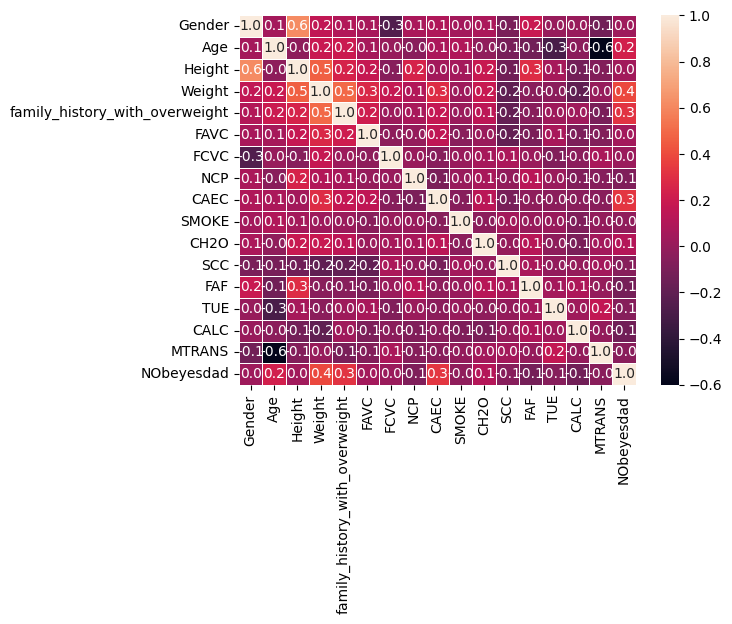

In [42]:
correlation = df_encoded[df_encoded.columns.to_list()].corr()

sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)
plt.show()

Plotando a matriz de correlação, é possível dizer que as variáveis são independentes, por conterem pouquíssima correlação entre si (números muito próximos a 0), ponto positivo para o modelo, por conta do algoritmo Naive Bayes, que é um classificador probabilístico que assume que as características (features) são independentes entre si, daí o termo “naive” (ingênuo). Essa é uma simplificação feita para facilitar o cálculo das probabilidades condicionais necessárias para classificação.

### Maldição da Dimensionalidade

In [43]:
len(df_x.columns)

16

Outro fator que pode estar prejudicando o desempenho do modelo é a alta quantidade de dimensões (colunas). Esse problema é denominado "Maldição da Dimensionalidade", termo introduzido pelo matemático R. Bellman, que se refere ao problema causado pelo aumento exponencial no volume associado à adição de dimensões extras a um espaço matemático.

Por exemplo:

Se dividirmos uma região do espaço em células regulares, o número de células cresce exponencialmente com a dimensão do espaço. Vamos denominar a dimensão como 
𝐷 e as células como 𝑁.


Se tivermos uma dimensão 𝐷1, com um número qualquer de células como 𝑁:


Ao aumentarmos uma dimensão, passando a ter 𝐷2, precisaremos ter o número de células como 𝑁^2.


Assim como 𝐷3 passaria a ter 𝑁^3, e assim por diante.


O que quero dizer é que, para um número qualquer de dimensões, é necessário ter a quantidade certa de amostras de dados. Isso nos leva a pensar que essa quantidade de amostras pode ser insuficiente ou excedente para essa quantidade de dimensões.

Algumas imagens que ilustram a explicação:

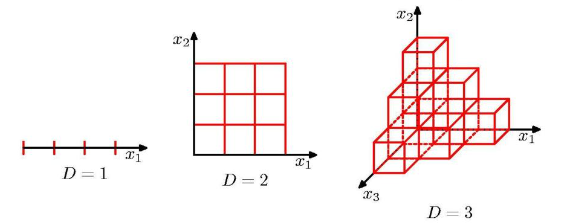

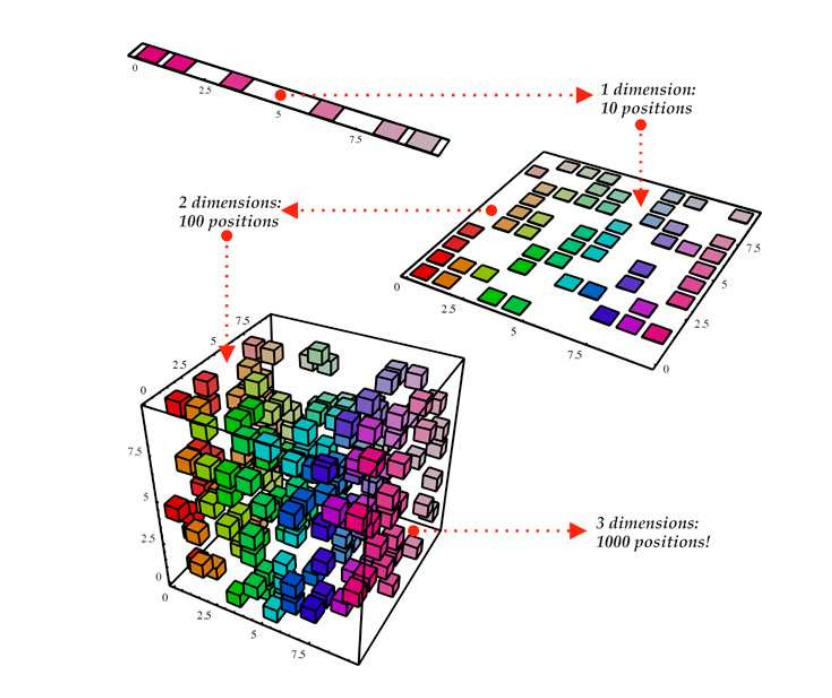

### Distribuição das Classes Resposta

Iremos verificar a distribuição das classes, por conta do GaussianNB se comportar mal com classes desbalanceadas. Ele tende a priorizar as classes majoritárias e pode ter dificuldade em prever corretamente as classes minoritárias.

In [44]:
display(df_y_encoded.value_counts())
display(y_train.value_counts())
display(y_test.value_counts())

NObeyesdad
2             351
4             324
3             297
5             290
6             290
1             287
0             272
dtype: int64

NObeyesdad
2             257
4             245
6             227
3             222
5             219
1             209
0             204
dtype: int64

NObeyesdad
2             94
4             79
1             78
3             75
5             71
0             68
6             63
dtype: int64

As classes resposta estão bem balanceadas, sem mostrar grandes disparidades

## Teste do Modelo Embasado Nos Resultados Anteriores e em Obter o Melhor Desempenho Possível do Modelo

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

### Importando e Tratando Todas as Bases Alterádas em Análise Axploratória

In [46]:
lista_df = [] # Lista para armazenar os dfs

In [47]:
lista_df.append(df)

df_capping = pd.read_excel('..\dados\df_capping.xlsx')
display(df_capping.head(2))
lista_df.append(df_capping)

df_iqr = pd.read_excel('..\dados\df_iqr.xlsx')
display(df_iqr.head(2))
lista_df.append(df_iqr)

df_log = pd.read_excel('..\dados\df_log.xlsx')
display(df_log.head(2))
lista_df.append(df_log)

df_raiz = pd.read_excel('..\dados\df_raiz.xlsx')
display(df_raiz.head(2))
lista_df.append(df_raiz)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,3.091042,1.62,64.0,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,3.091042,1.52,56.0,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,4.582576,1.62,64.0,yes,no,2,3,Sometimes,no,2,no,0,1,no,Public_Transportation,Normal_Weight
1,Female,4.582576,1.52,56.0,yes,no,3,3,Sometimes,yes,3,yes,3,0,Sometimes,Public_Transportation,Normal_Weight


In [48]:
df_capping.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [49]:
for k,v in enumerate(lista_df):
    ordem_colunas = lista_df[k].columns
    lista_df[k] = preprocessador.fit_transform(v)
    lista_df[k] = pd.DataFrame(lista_df[k], columns=preprocessador.get_feature_names_out())
    lista_df[k] = lista_df[k][ordem_colunas]


### PIPELINE

In [50]:
classificador_bayes.get_params()

{'priors': None, 'var_smoothing': 1e-09}

Esta pipeline será utilizada para, organizar os passos de transformação de dados e para tentar aplicar o melhor modelo possivel nas condições do nosso caso. Além disso, ela também é muito util para replicar o processo em outros modelos. 

### Explicação da Pipeline

- "df_metricas" -> DataFrame que armazena o nome do modelo, o DataFrame utilizado, as métricas de teste e a melhor combinação de hiperparâmetros encontrada.
  
- "pipe" -> Variável que armazena todos os processos que compõem a pipeline.
    - `StandardScaler` -> Centraliza os dados em torno de zero, subtraindo a média de cada coluna e dividindo pelo desvio padrão, normalizando a dispersão dos dados.
    - `SelectKBest` -> Seleciona as features mais importantes da base de dados, auxiliando na redução de dimensionalidade. Utilizo esse método para reduzir o número de perguntas que serão feitas ao usuário, de 16 para, no máximo, 10.
    - `PCA` -> Reduz a dimensionalidade após o SelectKBest, preservando o máximo de variância nos dados.
    - `GaussianNB` -> Modelo de machine learning utilizado após a redução de dimensionalidade.

- "params_pipe" -> Lista de parâmetros que serão testados na pipeline.
    - `SelectKBest__k` e `pca__n_components` -> Definem o número de colunas a serem mantidas na redução dimensional.
    - `SelectKBest__score_func` -> Funções de avaliação usadas para selecionar as colunas mais relevantes.
    - `model__var_smoothing` -> Adiciona uma pequena quantidade à variância de cada feature, evitando problemas numéricos e overfitting.

- "valores_k" -> Define o número máximo de colunas a serem selecionadas (até 10) pelo SelectKBest.

- GridSearchCV -> Executa a pipeline com diferentes combinações de hiperparâmetros, realiza validação cruzada e encontra a combinação que otimiza a acurácia.

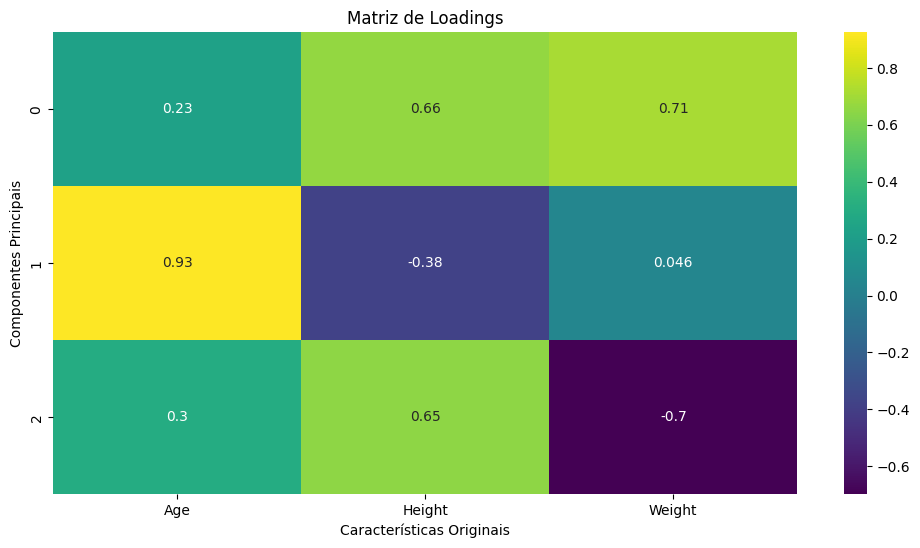

Melhores parametros:  {'SelectKBest__k': 3, 'SelectKBest__score_func': <function mutual_info_classif at 0x000002138AF785E0>, 'model__var_smoothing': 0.01519911082952933, 'pca__n_components': 3}
Melhor accuracy:  0.6582158687058259
              precision    recall  f1-score   support

         0.0       0.69      0.78      0.73        68
         1.0       0.51      0.49      0.50        78
         2.0       0.76      0.70      0.73        94
         3.0       0.71      0.80      0.75        75
         4.0       0.94      1.00      0.97        79
         5.0       0.45      0.41      0.43        71
         6.0       0.34      0.32      0.33        63

    accuracy                           0.65       528
   macro avg       0.63      0.64      0.63       528
weighted avg       0.64      0.65      0.65       528



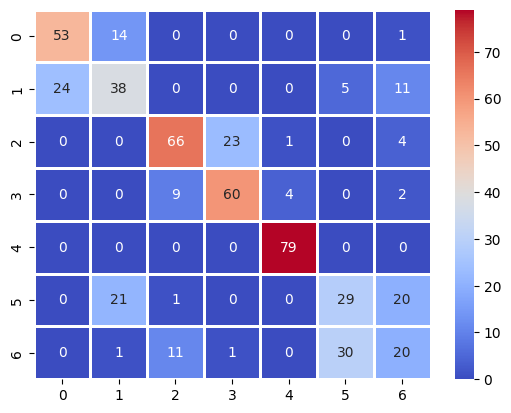

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


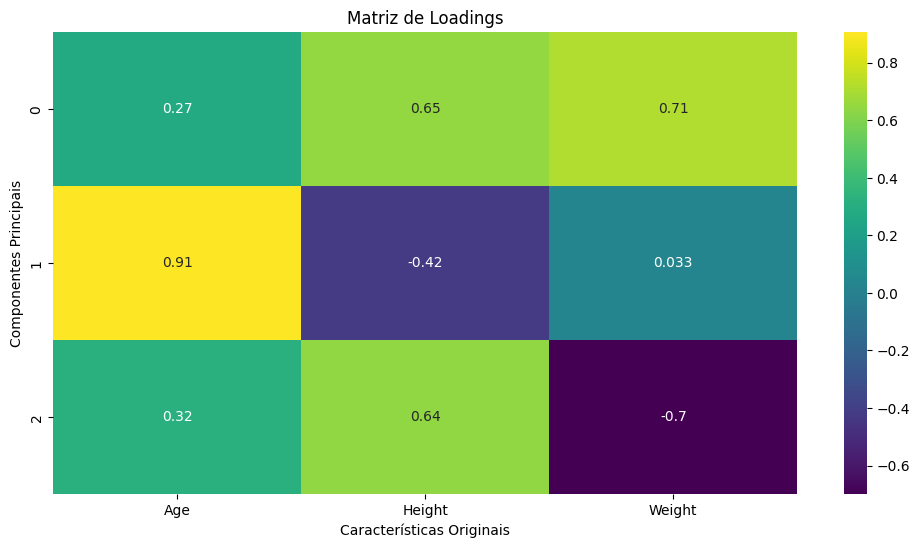

Melhores parametros:  {'SelectKBest__k': 3, 'SelectKBest__score_func': <function mutual_info_classif at 0x000002138AF785E0>, 'model__var_smoothing': 0.012328467394420659, 'pca__n_components': 3}
Melhor accuracy:  0.6658028191510601
              precision    recall  f1-score   support

         0.0       0.74      0.74      0.74        68
         1.0       0.47      0.59      0.52        78
         2.0       0.76      0.72      0.74        94
         3.0       0.74      0.84      0.79        75
         4.0       0.93      1.00      0.96        79
         5.0       0.33      0.20      0.25        71
         6.0       0.36      0.33      0.34        63

    accuracy                           0.65       528
   macro avg       0.62      0.63      0.62       528
weighted avg       0.63      0.65      0.63       528



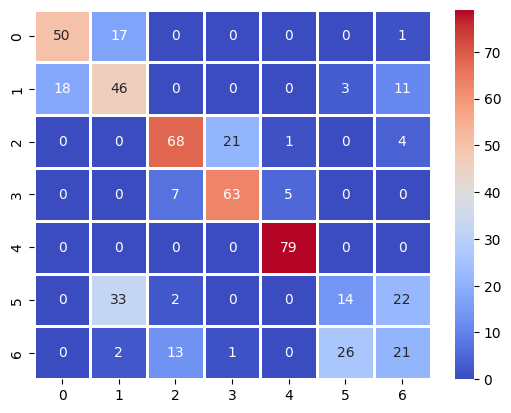

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


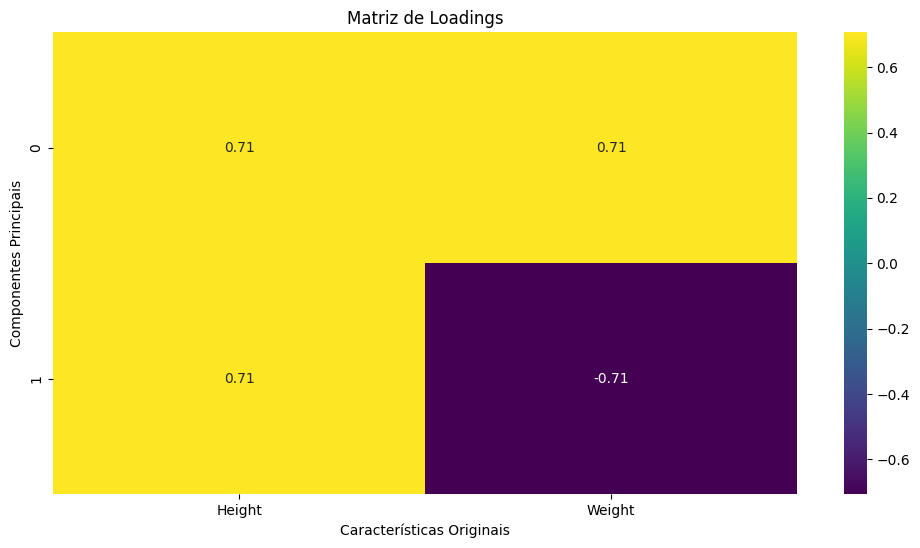

Melhores parametros:  {'SelectKBest__k': 2, 'SelectKBest__score_func': <function mutual_info_classif at 0x000002138AF785E0>, 'model__var_smoothing': 0.006579332246575682, 'pca__n_components': 2}
Melhor accuracy:  0.6883454398708636
              precision    recall  f1-score   support

         0.0       0.86      0.56      0.68        85
         1.0       0.46      0.69      0.55        70
         2.0       0.72      0.66      0.69        70
         3.0       0.64      0.81      0.72        64
         4.0       0.91      0.87      0.89        79
         5.0       0.71      0.70      0.70        66
         6.0       0.80      0.61      0.69        57

    accuracy                           0.70       491
   macro avg       0.73      0.70      0.70       491
weighted avg       0.73      0.70      0.71       491



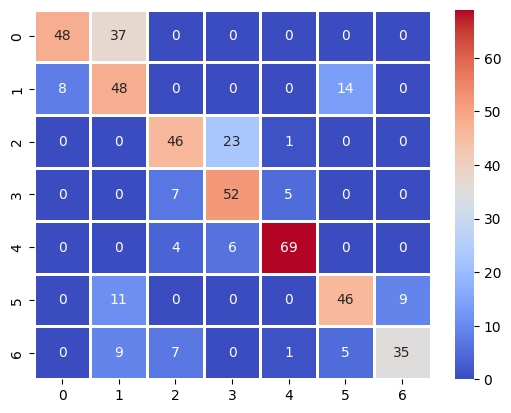

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


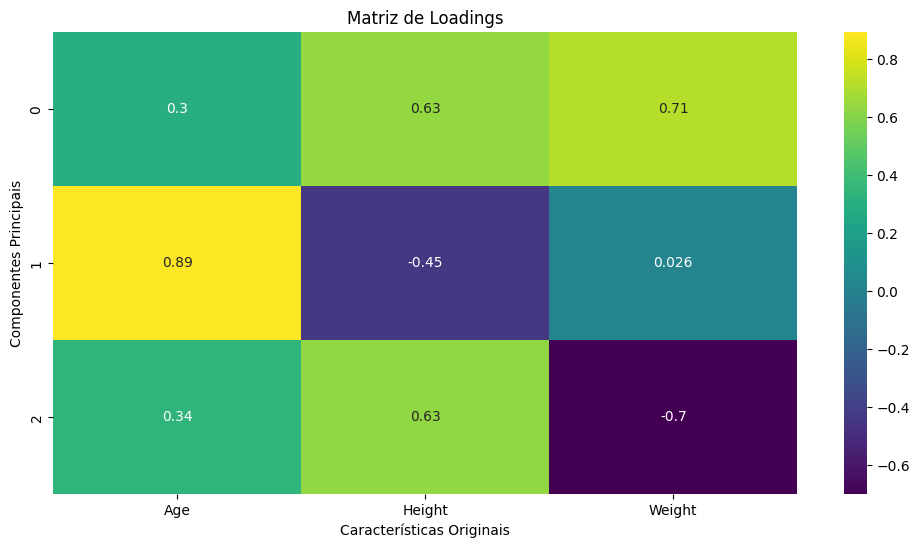

Melhores parametros:  {'SelectKBest__k': 3, 'SelectKBest__score_func': <function mutual_info_classif at 0x000002138AF785E0>, 'model__var_smoothing': 0.0004328761281083057, 'pca__n_components': 3}
Melhor accuracy:  0.6771832448189115
              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75        68
         1.0       0.61      0.56      0.59        78
         2.0       0.72      0.69      0.71        94
         3.0       0.75      0.84      0.79        75
         4.0       0.92      0.99      0.95        79
         5.0       0.52      0.48      0.50        71
         6.0       0.35      0.35      0.35        63

    accuracy                           0.68       528
   macro avg       0.66      0.67      0.66       528
weighted avg       0.67      0.68      0.67       528



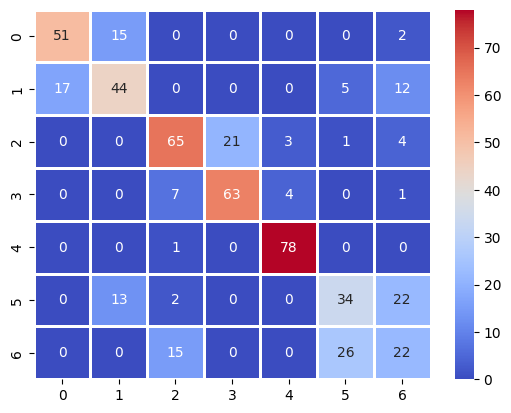

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


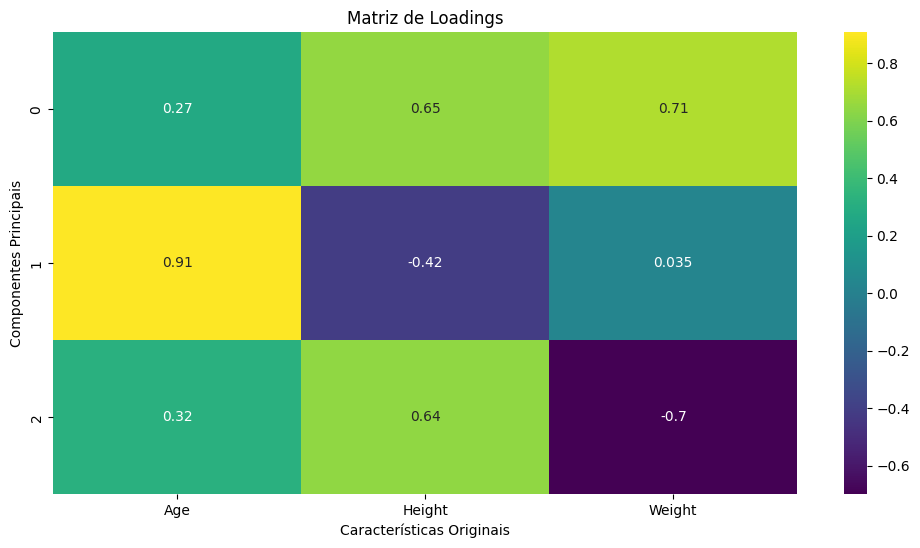

Melhores parametros:  {'SelectKBest__k': 3, 'SelectKBest__score_func': <function mutual_info_classif at 0x000002138AF785E0>, 'model__var_smoothing': 0.006579332246575682, 'pca__n_components': 3}
Melhor accuracy:  0.6670726350676836
              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76        68
         1.0       0.58      0.55      0.57        78
         2.0       0.73      0.71      0.72        94
         3.0       0.73      0.81      0.77        75
         4.0       0.93      1.00      0.96        79
         5.0       0.49      0.42      0.45        71
         6.0       0.34      0.33      0.34        63

    accuracy                           0.67       528
   macro avg       0.65      0.66      0.65       528
weighted avg       0.66      0.67      0.66       528



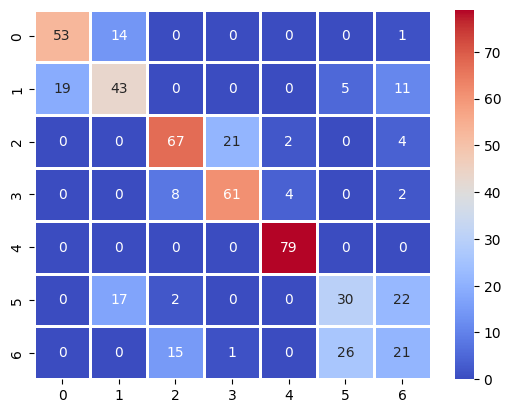

c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\arthurdomingos-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


,Modelo,DF,Quant_columns,Hyper_Parametros,Acuracia,Recall_Media,Precision_Media,F1_Score_Media
0,GaussianNB,Gender Age Height Weight fami...,3,"{'SelectKBest__k': 3, 'SelectKBest__score_func...",0.653409,0.64,0.63,0.63
1,GaussianNB,Gender Age Height Weight fami...,3,"{'SelectKBest__k': 3, 'SelectKBest__score_func...",0.645833,0.63,0.62,0.62
2,GaussianNB,Gender Age Height Weight fami...,2,"{'SelectKBest__k': 2, 'SelectKBest__score_func...",0.700611,0.70,0.73,0.70
3,GaussianNB,Gender Age Height Weight ...,3,"{'SelectKBest__k': 3, 'SelectKBest__score_func...",0.676136,0.67,0.66,0.66
4,GaussianNB,Gender Age Height Weight ...,3,"{'SelectKBest__k': 3, 'SelectKBest__score_func...",0.670455,0.66,0.65,0.65


In [51]:
df_metricas = pd.DataFrame(columns=['Modelo','DF','Quant_columns','Hyper_Parametros','Acuracia','Recall_Media', 'Precision_Media', 'F1_Score_Media'])

for data_frame in lista_df:
    X_train, X_test, y_train, y_test = train_test_split(data_frame[data_frame.columns[:-1]], data_frame['NObeyesdad'], test_size=0.25,random_state=42,shuffle=True)
    
    pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('SelectKBest', SelectKBest()),
                ('pca', PCA()),
                ('model', GaussianNB())
                ])
    

    params_pipe = []
    valores_k = range(1, 11)

    for k in valores_k:
        for n in range(1, k + 1):
    
            params_pipe.append({
                'SelectKBest__k': [k],
                'pca__n_components': [n],
                'SelectKBest__score_func':[f_classif,f_oneway,mutual_info_classif],
                'model__var_smoothing': np.logspace(0,-9, num=100),
            })

    grid_search = GridSearchCV(estimator = pipe,param_grid=params_pipe,n_jobs=-1,scoring='accuracy')

    grid_search.fit(X_train,y_train)


    pca =grid_search.best_estimator_.named_steps['pca']
    kBest = grid_search.best_estimator_.named_steps['SelectKBest']
    
    components_df = pd.DataFrame(pca.components_, columns=data_frame.columns[kBest.get_support(indices=True).tolist()])

    # Plotagem
    plt.figure(figsize=(12, 6))
    sns.heatmap(components_df, cmap='viridis', annot=True)
    plt.xlabel('Características Originais')
    plt.ylabel('Componentes Principais')
    plt.title('Matriz de Loadings')
    plt.show()

    # Analisando os resultados 
    melhor = grid_search.best_params_
    classificador_grafico = grid_search.best_estimator_ 
    print("Melhores parametros: ",melhor)
    print("Melhor accuracy: ",grid_search.best_score_)
    previsao = classificador_grafico.predict(X_test)
    metricas = classification_report(y_test,previsao)
    print(metricas)
    funcPlotMatriz(y_test, previsao)
    df_metricas = funcMetricas(df_metricas,'GaussianNB',data_frame,len(pca.components_),melhor,y_test,previsao)

display(df_metricas)        

### Algumas Conclusões

À primeira vista, a mudança pode parecer pequena, porém, tive que forçar o modelo a trabalhar com no máximo 10 colunas de características, uma redução significativa para um modelo que possuía 16 colunas no treinamento. Mesmo assim, ele conseguiu manter resultados semelhantes no teste simples e, em alguns casos, até melhores.

Outras conclusões que podem ser tiradas são que as colunas selecionadas, que tiveram o melhor desempenho na validação cruzada (Cross-Validation), foram:

- Age
- Height
- Weight
- family_history_with_overweight
- FAVC
- CAEC
- CH20
Por fim, as métricas obtidas pelo modelo não foram das melhores, e é provável que este não seja o melhor modelo para essa base de dados.

In [52]:
df_metricas.to_excel('..\comparacao_modelos\DataFrames\df_bayes.xlsx')
